In [1]:
import re
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv
from scenedetect import detect, AdaptiveDetector
from skimage.feature import graycomatrix, graycoprops
from skimage.metrics import structural_similarity as compare_ssim
import fast_colorthief
from PIL import Image as im
import math

import pickle
from sklearn import metrics

## Test Dataset

In [2]:
# load the presentation complexity test dataset
ptd_df = pd.read_csv('presentation_test_dataset_1.csv')
ptd_df.head()

,Video URL,Video Title,Presentation Complexity
0,https://www.youtube.com/watch?v=FqCQCWTdAQg,MP set Mathametical science syllabus,hard
1,https://youtu.be/fkkQhJQ2c_k?feature=shared,"GRADE 8, ENGLISH, UNIT 1",hard
2,https://www.youtube.com/watch?v=ETBiUsc5D-E,George Berkeley An overview of his life & his ...,hard
3,https://youtu.be/XE1EgLmS3mk?feature=shared,His First Flight Class 10 animation in English...,simple
4,https://www.youtube.com/watch?v=3ZpDjdFzQUM,Plate Boundaries-Divergent-Convergent-Transform,simple


In [3]:
# replace the categorical class labels (simple, hard) in 'Presentation Complexity' column to numerical values (0, 1)
ptd_df['Presentation Complexity'] = ptd_df['Presentation Complexity'].replace({'simple':0, 'hard':1})
ptd_df['Presentation Complexity'].value_counts()

1    15
0    15
Name: Presentation Complexity, dtype: int64

In [4]:
# video names in the test dataset may include characters that will not be present in the names of those video files in the directory if it is not allowed according to the naming rules
# so, remove all non-English alphabet characters except the digits from the video names in the dataset to be able to compare with the video file names in the directory
for video_name in ptd_df['Video Title']:
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    ptd_df.loc[ptd_df['Video Title'] == video_name, 'Cleaned Video Name'] = cleaned_video_name
    
ptd_df.head()

,Video URL,Video Title,Presentation Complexity,Cleaned Video Name
0,https://www.youtube.com/watch?v=FqCQCWTdAQg,MP set Mathametical science syllabus,1,MPsetMathameticalsciencesyllabus
1,https://youtu.be/fkkQhJQ2c_k?feature=shared,"GRADE 8, ENGLISH, UNIT 1",1,GRADE8ENGLISHUNIT1
2,https://www.youtube.com/watch?v=ETBiUsc5D-E,George Berkeley An overview of his life & his ...,1,GeorgeBerkeleyAnoverviewofhislifehisphilosophy...
3,https://youtu.be/XE1EgLmS3mk?feature=shared,His First Flight Class 10 animation in English...,0,HisFirstFlightClass10animationinEnglishTwoStor...
4,https://www.youtube.com/watch?v=3ZpDjdFzQUM,Plate Boundaries-Divergent-Convergent-Transform,0,PlateBoundariesDivergentConvergentTransform


## Manual Feature Engineering

In [5]:
# extract frames at a rate of 1fps (including the first frame) to reduce the number of extracted frames while retaining the essential information
def extract_frames(video_path):
    cap = None

    try:
        frame_num = 0
        frames = []

        cap = cv.VideoCapture(video_path)
        
        # check if the video file was opened successfully
        if not cap.isOpened():
            raise ValueError("Video file could not be opened.")

        while True:
            isTrue, frame = cap.read()

            if not isTrue:
                break

            if frame_num % int(cap.get(cv.CAP_PROP_FPS)) == 0:
                frames.append(frame)

            frame_num += 1

        return frames
    except Exception as e:
        sys.exit(f"Error: {e}")
    finally:
        if cap is not None:
            cap.release()

In [6]:
# 1. Frame Rate (fps)
# get the video's frame rate in frames per second (fps)
def get_frame_rate(video_path):
    cap = None

    try:
        cap = cv.VideoCapture(video_path)
        
        # check if the video file was opened successfully
        if not cap.isOpened():
            raise ValueError("Video file could not be opened.")
            
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        
        return frame_rate
    except Exception as e:
        sys.exit(f"Error: {e}")
    finally:
        if cap is not None:
            cap.release()

In [7]:
# 2. Scene Transition Rate (Per Minute)
# calculate the scene transition rate (per minute) using the formula: rate = total no. of scene transitions / video length (in minutes)
# adaptive detector algorithm is used to detect the scenes as it uses content detector algorithm for detection with minimal risk of detecting false scenes in situations like camera movements
# content detector algorithm detects scenes based on changes in colour and intensity between frames
def get_scene_trans_rate(video_path):
    cap = None

    try:
        scene_list = detect(video_path, AdaptiveDetector())
        
        if len(scene_list) == 0:
            total_scene_trans = 0
        else:
            total_scene_trans = len(scene_list) - 1

        cap = cv.VideoCapture(video_path)
        
        # check if the video file was opened successfully
        if not cap.isOpened():
            raise ValueError("Video file could not be opened.")
            
        total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        video_length = (total_frames/frame_rate)/60

        scene_trans_rate = total_scene_trans/video_length

        return scene_trans_rate
    except Exception as e:
        sys.exit(f"Error: {e}")
    finally:
        if cap is not None:
            cap.release()

In [8]:
# 3. Average Scene Duration (in Minutes)
# calculate the average scene duration in minutes using the formula: avg = total duration of all scenes (in minutes) / total no. of scenes
# if zero scenes are detected in a video, it means that there is only one scene spanning the whole video, so average scene duration = video length
# adaptive detector algorithm is used to detect the scenes as it uses content detector algorithm for detection with minimal risk of detecting false scenes in situations like camera movements
# content detector algorithm detects scenes based on changes in colour and intensity between frames
def get_avg_scene_dur(video_path):    
    try: 
        total_duration = 0

        scene_list = detect(video_path, AdaptiveDetector())

        for scene in scene_list:
            start_time = (scene[0].get_frames()/scene[0].get_framerate())/60
            end_time = (scene[1].get_frames()/scene[1].get_framerate())/60
            duration = end_time - start_time
            total_duration += duration

        avg_scene_dur = total_duration / len(scene_list)

        return avg_scene_dur
    except ZeroDivisionError:
        cap = None
            
        try:
            cap = cv.VideoCapture(video_path)
            
            # check if the video file was opened successfully
            if not cap.isOpened():
                raise ValueError("Video file could not be opened.")

            total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
            frame_rate = cap.get(cv.CAP_PROP_FPS)

            video_length = (total_frames/frame_rate)/60
            avg_scene_dur = video_length

            return avg_scene_dur
        finally:
            if cap is not None:
                cap.release()
    except Exception as e:
        sys.exit(f"Error: {e}")

In [9]:
# 4. Average Motion Intensity
# calculate the average motion intensity between one pair of consecutive frames using the formula: avg = total average magnitude of optical flow for all frame pairs / total number of frame pairs
# motion intensity is calculated using the optical flow method which detects the motion of objects between two consecutive frames in a video
# specifically, dense optical flow will be computed using the Gunnar Farneback algorithm as it looks at all the points in the image instead of corners like other algorithms
def get_avg_motion_intensity(frames):
    try:
        total_frame_pairs = len(frames) - 1
        total_avg_mag = 0

        # assign the first frame as the previous frame
        prv_f = frames[0]

        for n in range(len(frames)-1):    
            next_f = frames[n+1]

            # convert the previous frame from BGR to grayscale
            prv_f_gray = cv.cvtColor(prv_f, cv.COLOR_BGR2GRAY)
            # convert the next frame (subsequent frame in the list) from BGR to grayscale
            next_f_gray = cv.cvtColor(next_f, cv.COLOR_BGR2GRAY)

            # calculate optical flow between the two consecutive frames
            flow = cv.calcOpticalFlowFarneback(prv_f_gray, next_f_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            # calculate the magnitude of the optical flow
            mag, _= cv.cartToPolar(flow[..., 0], flow[..., 1])

            total_avg_mag += np.mean(mag)

            # assign the next frame as the previous frame for the next optical flow computation
            prv_f = next_f

        avg_motion_intensity = total_avg_mag/total_frame_pairs

        return avg_motion_intensity
    except Exception as e:
        sys.exit(f"Error: {e}")

In [10]:
# 5. Texture Features - Average Texture Contrast, Average Texture Homogeneity
# calculate the average texture contrast and average texture homogeneity in one frame using the formula: avg = total average contrast or total average homogeneity / total number of frames
# compute the texture contrast and texture homegeneity features using Gray Level Co-occurrence Matrix (GLCM) method
# GLCM provides rich texture information by considering the pixel intensity relationships between neighbouring pixels
# texture contrast indicates the size of the variations between the neighbouring pixel intensities
# texture homogeneity indicates how uniform the texture is
def get_texture_features(frames):
    try:
        total_avg_contrast = 0
        total_avg_homogeneity = 0

        for frame in frames:
            # convert the frame from 3D BGR array to 2D grayscale array
            frame_gray = cv.cvtColor(np.array(frame), cv.COLOR_BGR2GRAY)
            # scale the grayscale frame pixel values from the normalized range [0, 1] to the 8-bit range [0, 255]
            # convert the scaled pixel values into uint8 data type to represent the values from 0 to 255
            image = (255 * frame_gray).astype(np.uint8)

            # create glcm from the image with 255 different gray intensity levels, using a distance of 50 between two pixels that are in the vertical direction as the parameters 
            glcm = graycomatrix(image, distances=[50], angles=[np.pi/2], levels=256)

            # extract the texture features using glcm
            contrast = graycoprops(glcm, 'contrast')
            homogeneity = graycoprops(glcm, 'homogeneity')

            total_avg_contrast += np.mean(contrast)
            total_avg_homogeneity += np.mean(homogeneity)

        avg_contrast = total_avg_contrast/len(frames)
        avg_homogeneity = total_avg_homogeneity/len(frames)

        return avg_contrast, avg_homogeneity
    except Exception as e:
        sys.exit(f"Error: {e}")

In [11]:
# 6. Dominant Color Standard Deviation
# calculate the dominant color standard deviation which is the square root of variance in dominant color in each color channgel (R, G, B) across the frames in a video
def get_dom_color_sd(frames):
    try:
        dom_colors = []

        for frame in frames:
            # convert numpy array of frame to image format and save it because ColorThief method only accepts image file
            image = im.fromarray(frame)
            image.save('temp_img.jpg')

            try:
                # get the one most dominant color from each frame
                dom_color = fast_colorthief.get_dominant_color('temp_img.jpg', quality=1)
            except RuntimeError:
                # if the color is greater than rgb(250, 250, 250), it will not be included in the array of colors by fast_colorthief
                # this may result in an empty array of colors that will give an error during quantization 
                # quantization is the process of picking the dominant color by reducing the number of colors in the array of colors obtained from the image
                # if this error occurs, dominant color will be set to the rgb(255, 255, 255) which is the maximum value
                dom_color = [255, 255, 255]

            # store the dominant color of every frame in a list
            dom_colors.append(dom_color)

            # remove the image file to save space for storing the next frame as image using the same name
            os.remove('temp_img.jpg')

        dom_color_sd = np.std(dom_colors, axis=0, dtype=np.float64)

        return dom_color_sd
    except Exception as e:
        sys.exit(f"Error: {e}")

In [12]:
# 7. Bit Rate (Mbps)
# get the video's bit rate in mega bits per second (Mbps) using the formula bit rate = ((video file size * 8)/video_length)/(10^6)
# bit rate is the number of bits or amount of data conveyed per unit time
def get_bit_rate(video_path):
    cap = None
    
    try:
        video_file_size = os.path.getsize(video_path)

        cap = cv.VideoCapture(video_path)
        
        # check if the video file was opened successfully
        if not cap.isOpened():
            raise ValueError("Video file could not be opened.")
        
        total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        video_length = total_frames/frame_rate

        bit_rate = ((video_file_size * 8)/video_length)/(10**6)

        return bit_rate
    except Exception as e:
        sys.exit(f"Error: {e}")
    finally:
        if cap is not None:
            cap.release()

In [13]:
# 8. Compression Ratio
# calculate the compression ratio using the formula: ratio = compressed video file size (when downloaded)/uncompressed video file size
# uncompressed video file = frame height * frame width * bit depth * number of color channels * total number of frames
def get_comp_ratio(video_path):
    cap = None
    
    try:
        cap = cv.VideoCapture(video_path)
        
        # check if the video file was opened successfully
        if not cap.isOpened():
            raise ValueError("Video file could not be opened.")
    
        # video frame dimension
        height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        
        _, frame = cap.read()
        
        # bit depth which is the number of bits used to represent each color channel
        bit_depth = int(str(frame.dtype).removeprefix('uint'))
        # shape of RGB frame is (height, width, color channels)
        # shape of grayscale frame is (height, width)
        # number of color channels is the 3rd value in frame shape if it is RGB frame, otherwise it is 1 for grayscale frame
        num_col_channels = frame.shape[2] if len(frame.shape) == 3 else 1
        
        # total frames in the video
        total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        # calculate the uncompressed video file size in bytes
        uncompressed_size = (height * width * bit_depth * num_col_channels * total_frames) / 8
        
        # get the compressed video file size
        compressed_size = os.path.getsize(video_path)
        
        # calculate the compression ratip
        comp_ratio = compressed_size/uncompressed_size
    
        return comp_ratio
    except Exception as e:
        sys.exit(f"Error: {e}")
    finally:
        if cap is not None:
            cap.release()

In [14]:
# 9. Average Peak Signal-to-Noise Ratio (PSNR) (dB)
# calculate the PSNR in decibels (dB) between two consecutive images or frames
# PSNR indicates the quality of an image by computing the ratio between the maximum power of a signal and the power of noise in an image
def img_psnr(img1, img2):
    try:
        # compute mse
        mse = np.mean((img1 / 255.0 - img2 / 255.0) ** 2)

        # compute psnr
        if mse < 1e-10:
            psnr = 100
        else:
            psnr = 20 * math.log10(1 / math.sqrt(mse))

        return psnr
    except Exception as e:
        sys.exit(f"Error: {e}")

# calculate the PSNR for all the frames in a video and find the average PSNR in decibals (dB)
def calculate_avg_psnr(frames):
    try:
        psnr_results = []

        for i in range(1, len(frames)):
            psnr = img_psnr(frames[i - 1], frames[i])
            psnr_results.append(psnr)

        mean_psnr = np.mean(psnr_results) if psnr_results else 0

        return mean_psnr
    except Exception as e:
        sys.exit(f"Error: {e}")

In [15]:
# 10. Average Structural Similarity Index (SSIM)
# calculate the SSIM between two consecutive images or frames
# SSIM measures the similarity between two images based on the difference in luminance, contrast, and structure
def img_ssim(img1, img2):
    try:
        # convert images to grayscale for SSIM calculation
        img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
        img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

        ssim_index, _ = compare_ssim(img1_gray, img2_gray, full=True)

        return ssim_index
    except Exception as e:
        sys.exit(f"Error: {e}")

# calculate the SSIM for all the frames in a video and find the average SSIM
def calculate_avg_ssim(frames):
    try:
        ssim_results = []

        for i in range(1, len(frames)):
            ssim = img_ssim(frames[i - 1], frames[i])
            ssim_results.append(ssim)

        mean_ssim = np.mean(ssim_results) if ssim_results else 0

        return mean_ssim
    except Exception as e:
        sys.exit(f"Error: {e}")

In [16]:
# 11. Average Color Standard Deviation
# calculate the average color standard deviation which is the square root of variance in average color in each color channel (R, G, B) across all the frames in the video
def get_avg_col_sd(frames):
    try:
        avg_frame_cols = []

        for frame in frames:
            avg_fcol_row = np.mean(frame, axis=0)
            avg_fcol = np.mean(avg_fcol_row, axis=0)
            # store the average color of each frame in a list
            avg_frame_cols.append(avg_fcol)

        avg_col_sd = np.std(avg_frame_cols, axis=0, dtype=np.float64)

        return avg_col_sd
    except Exception as e:
        sys.exit(f"Error: {e}")  

In [5]:
# get the test video file names
video_files = os.listdir('Presentation Test Videos (Phase 1)')
len(video_files)

30

In [6]:
# peform manual feature engineering
count = 0
folder = 'Presentation Test Videos (Phase 1)'

for file in video_files:
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    video_path = os.path.join(folder, file)

    frames = extract_frames(video_path)

    frame_rate = get_frame_rate(video_path)
    scene_trans_rate = get_scene_trans_rate(video_path)
    avg_scene_dur = get_avg_scene_dur(video_path)
    avg_motion_int = get_avg_motion_intensity(frames)
    avg_contrast, avg_homogeneity = get_texture_features(frames)
    dom_col_sd = get_dom_color_sd(frames)
    bit_rate = get_bit_rate(video_path)
    compression_ratio = get_comp_ratio(video_path)
    avg_psnr = calculate_avg_psnr(frames)
    avg_ssim = calculate_avg_ssim(frames)
    avg_col_sd = get_avg_col_sd(frames)

    features = {'Frame Rate (fps)': frame_rate,
              'Scene Transition Rate (Per Min)': scene_trans_rate,
              'Average Scene Duration (in Mins)': avg_scene_dur,
              'Average Motion Intensity': avg_motion_int,
              'Average Texture Contrast': avg_contrast,
              'Average Texture Homogeneity': avg_homogeneity,
              'Dominant Color Standard Deviation (R)': dom_col_sd[0],
              'Dominant Color Standard Deviation (G)': dom_col_sd[1],
              'Dominant Color Standard Deviation (B)': dom_col_sd[2],
              'Bit Rate (Mbps)': bit_rate,
              'Compression Ratio': compression_ratio,
              'Average PSNR (dB)': avg_psnr,
              'Average SSIM': avg_ssim,
              'Average Color Standard Deviation (R)': avg_col_sd[0],
              'Average Color Standard Deviation (G)': avg_col_sd[1],
              'Average Color Standard Deviation (B)': avg_col_sd[2]}

    # store the manually engineerd features in the test dataset
    row_idx = ptd_df[ptd_df['Cleaned Video Name'] == cleaned_video_name].index

    for feature, value in features.items():
        ptd_df.at[row_idx[0], feature] = value

    count += 1
    if count % 5 == 0:
      print(f"{count} videos completed")

5 videos completed
10 videos completed
15 videos completed
20 videos completed
25 videos completed
30 videos completed


In [7]:
ptd_df.head()

,Video URL,Video Title,Presentation Complexity,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB),Average SSIM,Average Color Standard Deviation (R),Average Color Standard Deviation (G),Average Color Standard Deviation (B)
0,https://www.youtube.com/watch?v=FqCQCWTdAQg,MP set Mathametical science syllabus,1,MPsetMathameticalsciencesyllabus,29.600000,0.362264,1.840278,5.992437,853.265808,0.376878,11.588977,12.356016,11.198465,1.863310,0.002846,18.372113,0.664803,9.012597,9.865375,7.973724
1,https://youtu.be/fkkQhJQ2c_k?feature=shared,"GRADE 8, ENGLISH, UNIT 1",1,GRADE8ENGLISHUNIT1,29.845000,0.673406,1.272846,0.463185,5802.763797,0.565287,100.486312,96.209403,91.089927,0.473885,0.000856,31.858830,0.962784,7.034477,6.995443,7.446200
2,https://www.youtube.com/watch?v=ETBiUsc5D-E,George Berkeley An overview of his life & his ...,1,GeorgeBerkeleyAnoverviewofhislifehisphilosophy...,47.952048,2.277092,0.432503,0.553988,7323.480714,0.551770,85.626882,84.792838,82.070221,0.557295,0.000643,52.200184,0.961578,39.757743,38.936062,38.939747
3,https://youtu.be/XE1EgLmS3mk?feature=shared,His First Flight Class 10 animation in English...,0,HisFirstFlightClass10animationinEnglishTwoStor...,24.000000,3.405405,0.274074,1.570079,1398.269565,0.156339,47.769189,38.353745,36.417193,0.354507,0.000668,24.257495,0.904651,37.125485,29.370997,24.172436
4,https://www.youtube.com/watch?v=3ZpDjdFzQUM,Plate Boundaries-Divergent-Convergent-Transform,0,PlateBoundariesDivergentConvergentTransform,25.000000,4.869001,0.191689,3.084297,3629.381880,0.450872,91.831294,73.309047,71.923694,0.738623,0.001336,43.252699,0.875511,47.471495,54.668783,68.247276


In [8]:
ptd_df.isnull().sum()

Video URL                                0
Video Title                              0
Presentation Complexity                  0
Cleaned Video Name                       0
Frame Rate (fps)                         0
Scene Transition Rate (Per Min)          0
Average Scene Duration (in Mins)         0
Average Motion Intensity                 0
Average Texture Contrast                 0
Average Texture Homogeneity              0
Dominant Color Standard Deviation (R)    0
Dominant Color Standard Deviation (G)    0
Dominant Color Standard Deviation (B)    0
Bit Rate (Mbps)                          0
Compression Ratio                        0
Average PSNR (dB)                        0
Average SSIM                             0
Average Color Standard Deviation (R)     0
Average Color Standard Deviation (G)     0
Average Color Standard Deviation (B)     0
dtype: int64

In [39]:
ptd_df.to_csv('presentation_test_dataset_features_1.csv', index=False)

## Making Predictions

In [37]:
# load the trained Random Forest model back from file
model_path = 'C:/Users/kavis/Desktop/Junior-Senior Project (UOS)/AI Implementation/Presentation Complexity/Model Development and Evaluation (Phase 1)/trained_rf_model_1.pkl'

with open(model_path, 'rb') as file:  
    trained_rf_model = pickle.load(file)

trained_rf_model

RandomForestClassifier(max_features=None, n_estimators=200, random_state=42)

In [38]:
# load the min max scaler back from file
scaler_path = 'C:/Users/kavis/Desktop/Junior-Senior Project (UOS)/AI Implementation/Presentation Complexity/Model Development and Evaluation (Phase 1)/scaler_1.pkl'

with open(scaler_path, 'rb') as file:  
    scaler = pickle.load(file)

scaler

MinMaxScaler()

In [24]:
features = ptd_df.iloc[:, 5:]
features.head()

,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB),Average SSIM,Average Color Standard Deviation (R),Average Color Standard Deviation (G),Average Color Standard Deviation (B)
0,29.600000,0.362264,1.840278,5.992437,853.265808,0.376878,11.588977,12.356016,11.198465,1.863310,0.002846,18.372113,0.664803,9.012597,9.865375,7.973724
1,29.845000,0.673406,1.272846,0.463185,5802.763797,0.565287,100.486312,96.209403,91.089927,0.473885,0.000856,31.858830,0.962784,7.034477,6.995443,7.446200
2,47.952048,2.277092,0.432503,0.553988,7323.480714,0.551770,85.626882,84.792838,82.070221,0.557295,0.000643,52.200184,0.961578,39.757743,38.936062,38.939747
3,24.000000,3.405405,0.274074,1.570079,1398.269565,0.156339,47.769189,38.353745,36.417193,0.354507,0.000668,24.257495,0.904651,37.125485,29.370997,24.172436
4,25.000000,4.869001,0.191689,3.084297,3629.381880,0.450872,91.831294,73.309047,71.923694,0.738623,0.001336,43.252699,0.875511,47.471495,54.668783,68.247276


In [26]:
# normalize input features using min max scaler
normalized_features = scaler.transform(features)

In [27]:
# make presentation complexity predictions
pc_pred = trained_rf_model.predict(normalized_features)

In [10]:
# store presentation complexity predictions in the test dataset
ptd_df['Predicted Presentation Complexity'] = pc_pred
ptd_df.head()

,Video URL,Video Title,Presentation Complexity,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,...,Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB),Average SSIM,Average Color Standard Deviation (R),Average Color Standard Deviation (G),Average Color Standard Deviation (B),Predicted Presentation Complexity
0,https://www.youtube.com/watch?v=FqCQCWTdAQg,MP set Mathametical science syllabus,1,MPsetMathameticalsciencesyllabus,29.600000,0.362264,1.840278,5.992437,853.265808,0.376878,...,12.356016,11.198465,1.863310,0.002846,18.372113,0.664803,9.012597,9.865375,7.973724,0
1,https://youtu.be/fkkQhJQ2c_k?feature=shared,"GRADE 8, ENGLISH, UNIT 1",1,GRADE8ENGLISHUNIT1,29.845000,0.673406,1.272846,0.463185,5802.763797,0.565287,...,96.209403,91.089927,0.473885,0.000856,31.858830,0.962784,7.034477,6.995443,7.446200,1
2,https://www.youtube.com/watch?v=ETBiUsc5D-E,George Berkeley An overview of his life & his ...,1,GeorgeBerkeleyAnoverviewofhislifehisphilosophy...,47.952048,2.277092,0.432503,0.553988,7323.480714,0.551770,...,84.792838,82.070221,0.557295,0.000643,52.200184,0.961578,39.757743,38.936062,38.939747,0
3,https://youtu.be/XE1EgLmS3mk?feature=shared,His First Flight Class 10 animation in English...,0,HisFirstFlightClass10animationinEnglishTwoStor...,24.000000,3.405405,0.274074,1.570079,1398.269565,0.156339,...,38.353745,36.417193,0.354507,0.000668,24.257495,0.904651,37.125485,29.370997,24.172436,0
4,https://www.youtube.com/watch?v=3ZpDjdFzQUM,Plate Boundaries-Divergent-Convergent-Transform,0,PlateBoundariesDivergentConvergentTransform,25.000000,4.869001,0.191689,3.084297,3629.381880,0.450872,...,73.309047,71.923694,0.738623,0.001336,43.252699,0.875511,47.471495,54.668783,68.247276,0


In [40]:
ptd_df.to_csv('presentation_test_dataset_features_preds_1.csv', index=False)

## Model Performance Evaluation

In [13]:
# plot normalized confusion matrix using the actual and predicted values
def plot_norm_confusion_matrix(video_type, y_actual, y_pred):
    plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
    
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_actual, y_pred, normalize='true', values_format='.2f', display_labels=['simple', 'hard'], cmap=plt.cm.Purples)
    plt.title(f'Normalized Confusion Matrix for {video_type}', pad=10)
    plt.show()

In [14]:
actual = ptd_df['Presentation Complexity']
pred = ptd_df['Predicted Presentation Complexity']

Accuracy (Test Videos) = 0.733


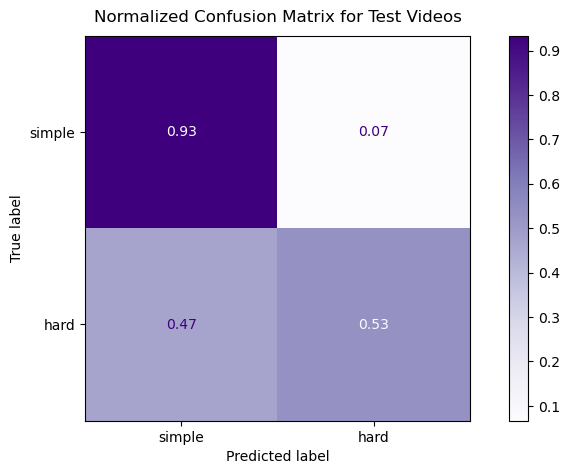

In [15]:
print(f"Accuracy (Test Videos) = {round(metrics.accuracy_score(actual, pred), 3)}")
plot_norm_confusion_matrix('Test Videos', actual, pred)